# Increase the polynomial degree

-- We will test the model with different polynomial degrees and see if we can improve the error

In [1]:

# Import libraries
import pandas as pd

# Read the CSV file
data = pd.read_csv('./data/emissions.csv')

# Drop unnecessary columns
data = data.drop(columns=['Sector', 'Parent sector'])

# Melt the dataframe to have a long format with 'year' and 'emissions' columns
data = data.melt(id_vars=['Country'], var_name='year', value_name='emissions')

# Convert the year column to integer
data['year'] = data['year'].astype(int)


In [2]:
# Add One-Hot encoding for Countries

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoded_countries = encoder.fit_transform(data[['Country']])
encoded_countries_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(['Country']))

# Combine the encoded countries with the original data
data_encoded = pd.concat([encoded_countries_df, data[['year', 'emissions']]], axis=1)

print(data_encoded)


/Users/alex/opt/anaconda3/envs/fastapi-vizz-challenge/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


        Country_ABW  Country_AFG  Country_AGO  Country_AIA  Country_ALB  \
0               1.0          0.0          0.0          0.0          0.0   
1               0.0          1.0          0.0          0.0          0.0   
2               0.0          0.0          1.0          0.0          0.0   
3               0.0          0.0          0.0          1.0          0.0   
4               0.0          0.0          0.0          0.0          1.0   
...             ...          ...          ...          ...          ...   
799915          0.0          0.0          0.0          0.0          0.0   
799916          0.0          0.0          0.0          0.0          0.0   
799917          0.0          0.0          0.0          0.0          0.0   
799918          0.0          0.0          0.0          0.0          0.0   
799919          0.0          0.0          0.0          0.0          0.0   

        Country_AND  Country_ANT  Country_ARE  Country_ARG  Country_ARM  ...  \
0               0.0

I should apply the PolynomialFeatures only to the 'year' column, not the 'emissions' column. The 'emissions' column is the target variable that I want to predict, so you should not transform it with PolynomialFeatures.

The reason for applying PolynomialFeatures to the 'year' column is to create higher-degree terms that can help the model capture non-linear relationships between the year and the emissions. The 'year' column is the only numerical feature in your dataset that can be transformed in this way.

Processing degree 1
Adding polynomial features...
Number of features after adding polynomial terms: 211 with degree 1
Number of features after scaling: 211
Training the model...
Model trained!
Computing training MSE...
Training MSE: 152272.91
Computing CV MSE...
Time consumed traininging: 35.22189688682556 seconds ---
Degree 1 - Train MSE: 152272.91, CV MSE: 153546.72


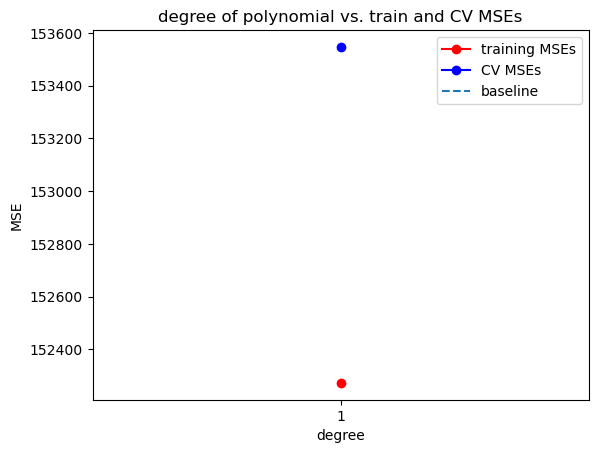

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time

# Split the data into train, cross-validation, and test sets
X = data_encoded.drop(columns=['emissions'])
y = data_encoded['emissions']
# Create the model
model = LinearRegression()


# Test different polynomial degrees in a loop

def train_plot_poly(model, X, y, max_degree=10, test_size=0.2, baseline=None):
    # Split the dataset into train and validation sets
    X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=test_size, random_state=42)

    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1, max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:
        print(f"Processing degree {degree}")

        # check time consumed training:

        start_time = time.time()

        # Add polynomial features to the training set
        print("Adding polynomial features...")
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(X_train)
        print(f"Number of features after adding polynomial terms: {X_train_mapped.shape[1]} with degree {degree}")

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)
        print("Number of features after scaling: %s" % X_train_mapped_scaled.shape[1])

        # Create and train the model
        print("Training the model...")
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)
        print("Model trained!")

        # Compute the training MSE
        print("Computing training MSE...")
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)
        print(f"Training MSE: {train_mse:.2f}")

        # Add polynomial features and scale the cross-validation set
        X_cv_mapped = poly.transform(X_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        print("Computing CV MSE...")
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

        print("Time consumed traininging: %s seconds ---" % (time.time() - start_time))

        print(f"Degree {degree} - Train MSE: {train_mse:.2f}, CV MSE: {cv_mse:.2f}")

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs')
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs')
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


train_plot_poly(model, X, y, max_degree=1, test_size=0.2, baseline=None)



# The process stuck adding degree 2 polynomial features. I will try to run it again with a smaller dataset.
